# HW08 - Instrumental Variables (due November 23rd)

In this homework you will practice with running IV regressions with python. You will investigate once more the effect of schooling on earnings, but this time the instrument for education you will use is college proximity to individuals houses (reference paper by [Card, 1993](https://davidcard.berkeley.edu/papers/geo_var_schooling.pdf)).

More in detail, there are two instruments that can be exploited in this context. Both are binary variables taking value 1 if either a 2-years or 4-years college is present in the area where the individual lives.

In [21]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from linearmodels.iv import IV2SLS
from statsmodels.iolib.summary2 import summary_col
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

df = pd.read_stata('http://www.stata.com/data/jwooldridge/eacsap/card.dta')
pd.read_stata('http://www.stata.com/data/jwooldridge/eacsap/card.dta', iterator=True).variable_labels()

{'id': '',
 'nearc2': '=1 if near 2 yr college, 1966',
 'nearc4': '=1 if near 4 yr college, 1966',
 'educ': 'years of schooling, 1976',
 'age': 'in years',
 'fatheduc': "father's schooling",
 'motheduc': "mother's schooling",
 'weight': 'NLS sampling weight, 1976',
 'momdad14': '=1 if live with mom, dad at 14',
 'sinmom14': '=1 if with single mom at 14',
 'step14': '=1 if with step parent at 14',
 'reg661': 'regional dummy, 1966',
 'reg662': '',
 'reg663': '',
 'reg664': '',
 'reg665': '',
 'reg666': '',
 'reg667': '',
 'reg668': '',
 'reg669': '',
 'south66': '=1 if in south in 1966',
 'black': '=1 if black',
 'smsa': '=1 in in SMSA, 1976',
 'south': '=1 if in south, 1976',
 'smsa66': '=1 if in SMSA, 1966',
 'wage': 'hourly wage in cents, 1976',
 'enroll': '=1 if enrolled in school, 1976',
 'kww': 'knowledge world of work score',
 'iq': 'IQ score',
 'married': '=1 if married, 1976',
 'libcrd14': '=1 if lib. card in home at 14',
 'exper': 'age - educ - 6',
 'lwage': 'log(wage)',
 'expe

In [22]:
df.head()

,id,nearc2,nearc4,educ,age,fatheduc,motheduc,weight,momdad14,sinmom14,...,smsa66,wage,enroll,kww,iq,married,libcrd14,exper,lwage,expersq
0,2,0,0,7,29,NaN,NaN,158413.0,1,0,...,1,548,0,15.0,NaN,1.0,0.0,16,6.306275,256
1,3,0,0,12,27,8.0,8.0,380166.0,1,0,...,1,481,0,35.0,93.0,1.0,1.0,9,6.175867,81
2,4,0,0,12,34,14.0,12.0,367470.0,1,0,...,1,721,0,42.0,103.0,1.0,1.0,16,6.580639,256
3,5,1,1,11,27,11.0,12.0,380166.0,1,0,...,1,250,0,25.0,88.0,1.0,1.0,10,5.521461,100
4,6,1,1,12,34,8.0,7.0,367470.0,1,0,...,1,729,0,34.0,108.0,1.0,0.0,16,6.591674,256


### OLS

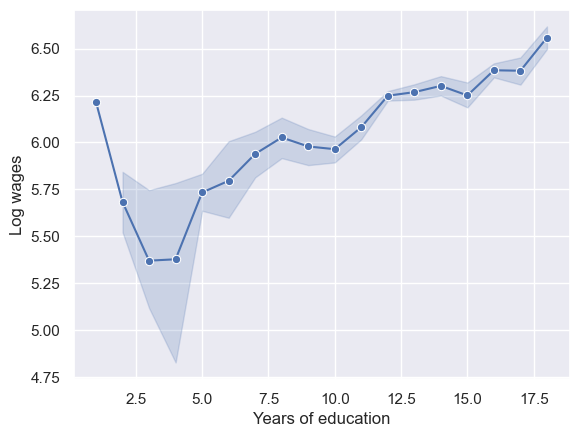

In [23]:
##plot log wages against education
sns.set_theme()
plot = sns.lineplot(data=df, y='lwage', x='educ', ci=95, marker='o')
plot.set(xlabel='Years of education', ylabel='Log wages')
plt.show()


In [41]:
##Regress log wages (lwage) against education and include controls, use robust standard errors.
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

covariates = ['age', 'south', 'kww', 'iq', 'fatheduc', 'motheduc']

ols = smf.ols("lwage ~ educ + age + south + kww + iq + fatheduc + motheduc", df).fit(cov_type='hc1')
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     53.67
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           4.76e-69
Time:                        18:36:35   Log-Likelihood:                -719.17
No. Observations:                1604   AIC:                             1454.
Df Residuals:                    1596   BIC:                             1497.
Df Model:                           7                                         
Covariance Type:                  hc1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4741      0.128     35.012      0.000       4.224       4.725
educ           0.0170      0.005      3.248      0.001       0.007       0.027
age            0.0415      0.004     11.144      0.000       0.034       0.049
south         -0.1040      0.021     -4.979      0.000      -0.145      -0.063
kww            0.0059      0.002      3.596      0.000       0.003       0.009
iq             0.0021      0.001      2.544      0.011       0.000       0.004
fatheduc      -0.0017      0.004     -0.446      0.656      -0.009       0.006
motheduc       0.0073      0.004      1.643      0.100      -0.001       0.016
==============================================================================
Omnibus:                       45.978   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.700
Skew:                          -0.329   Prob(JB):                     1.79e-13
Kurtosis:                       3.668   Cond. No.                     1.53e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**What are other possible confunders?**

> Family wealth when attending school, health conditions

### 2SLS

You will use only on proximity to a 4-years college ($nearc4$) as instrument. 

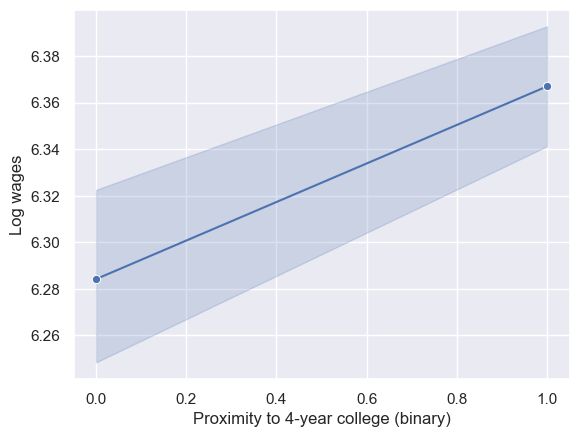

In [27]:
##plot log wages against nearc4
sns.set_theme()
plot = sns.lineplot(data=df, y='lwage', x='nearc4', ci=95, marker='o')
plot.set(xlabel='Proximity to 4-year college (binary)', ylabel='Log wages')
plt.show()

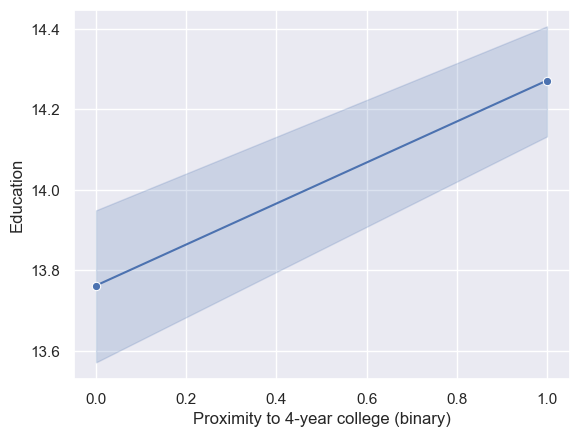

In [28]:
##plot education against nearc4
sns.set_theme()
plot = sns.lineplot(data=df, y='educ', x='nearc4', ci=95, marker='o')
plot.set(xlabel='Proximity to 4-year college (binary)', ylabel='Education')
plt.show()

**If you run an IV regression of log wages on education, using college proximity as an instrument for education, what would you expect the sign of the coefficient on education to be? Why?**

> I would expect a positive sign since college proximity is positively correlated to education and log_wages

In [43]:
##run a regression of education on nearc4, adding the controls you selected before and using robust standard errors
fs = smf.ols("educ ~ nearc4 + age + south + kww + iq + fatheduc + motheduc", df).fit(cov_type='hc1')
fs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   educ   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     152.7
Date:                Tue, 22 Nov 2022   Prob (F-statistic):          1.27e-172
Time:                        18:38:08   Log-Likelihood:                -3236.5
No. Observations:                1604   AIC:                             6489.
Df Residuals:                    1596   BIC:                             6532.
Df Model:                           7                                         
Covariance Type:                  hc1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7125      0.602      6.169      0.000       2.533       4.892
nearc4         0.3066      0.104      2.951      0.003       0.103       0.510
age            0.0184      0.018      1.001      0.317      -0.018       0.055
south          0.3708      0.098      3.773      0.000       0.178       0.563
kww            0.0507      0.007      6.782      0.000       0.036       0.065
iq             0.0521      0.004     14.334      0.000       0.045       0.059
fatheduc       0.1225      0.018      6.900      0.000       0.088       0.157
motheduc       0.0922      0.021      4.385      0.000       0.051       0.133
==============================================================================
Omnibus:                       28.453   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.956
Skew:                           0.231   Prob(JB):                     6.28e-06
Kurtosis:                       2.619   Cond. No.                     1.51e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
##predict education from the previous regression
df['educhat'] = fs.predict()

In [46]:
##run a regression of log wages on education and controls using robust standard errors
twosls = smf.ols("lwage ~ educhat + age + south + kww + iq + fatheduc + motheduc", df).fit(cov_type='hc1')
twosls.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     53.93
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           2.30e-69
Time:                        18:39:48   Log-Likelihood:                -722.51
No. Observations:                1604   AIC:                             1461.
Df Residuals:                    1596   BIC:                             1504.
Df Model:                           7                                         
Covariance Type:                  hc1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0033      0.290     13.806      0.000       3.435       4.572
educhat        0.1389      0.067      2.062      0.039       0.007       0.271
age            0.0391      0.004      9.863      0.000       0.031       0.047
south         -0.1426      0.030     -4.784      0.000      -0.201      -0.084
kww           -0.0003      0.004     -0.067      0.946      -0.008       0.007
iq            -0.0043      0.004     -1.199      0.230      -0.011       0.003
fatheduc      -0.0170      0.009     -1.831      0.067      -0.035       0.001
motheduc      -0.0038      0.008     -0.503      0.615      -0.019       0.011
==============================================================================
Omnibus:                       48.162   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.499
Skew:                          -0.334   Prob(JB):                     2.68e-14
Kurtosis:                       3.698   Cond. No.                     3.71e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 3.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
##compare the 2sls and ols estimates 
print(summary_col([ols, twosls], float_format='%0.3f',  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}, regressor_order=['educ', 'educhat']))


               lwage I lwage II
-------------------------------
educ           0.017           
               (0.005)         
educhat                0.139   
                       (0.067) 
Intercept      4.474   4.003   
               (0.128) (0.290) 
age            0.041   0.039   
               (0.004) (0.004) 
fatheduc       -0.002  -0.017  
               (0.004) (0.009) 
iq             0.002   -0.004  
               (0.001) (0.004) 
kww            0.006   -0.000  
               (0.002) (0.004) 
motheduc       0.007   -0.004  
               (0.004) (0.008) 
south          -0.104  -0.143  
               (0.021) (0.030) 
R-squared      0.183   0.179   
R-squared Adj. 0.179   0.176   
N              1604    1604    
Standard errors in parentheses.


**What do you think the difference in the estimates is due to?**

> Educhat probably contains additional information like wealth (assuming that neighborhood around colleges are expensive)

### IV analysis

In [48]:
##use IV2sls to run the regression of log wages on education. using college proximity as an instrument for education
##add the same controls as 

exog = sm.add_constant(df[covariates])
iv2sls = IV2SLS(df.lwage, exog, df.educ, df['nearc4']).fit(cov_type='robust')
print(iv2sls)


                          IV-2SLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                     -0.0993
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1041
No. Observations:                1604   F-statistic:                    275.28
Date:                Tue, Nov 22 2022   P-value (F-stat)                0.0000
Time:                        19:20:55   Distribution:                  chi2(7)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          4.0033     0.3438     11.643     0.0000      3.3294      4.6772
age            0.0391     0.0045     8.7264     0.00